# Satellite Image Classification

In [1]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/MyDrive/Colab_Notebooks/CSE527_Final_Project

In [2]:
# !ls

## Librirary Installation

In [3]:
import os
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


## Data preprocessing

### Data Loading

In [4]:
ROOT = os.getcwd()
PATH = ROOT + "/data/data"
file_types = ('*.jpg')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

dataset = tf.keras.preprocessing.image_dataset_from_directory(PATH,
                                                              shuffle = True,
                                                              label_mode = 'categorical',
                                                              batch_size = BATCH_SIZE,
                                                              image_size = IMG_SIZE)

Found 5631 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
num_classes = len(class_names)
print(num_classes)
print(class_names)

4
['cloudy', 'desert', 'green_area', 'water']


### Visualization of image

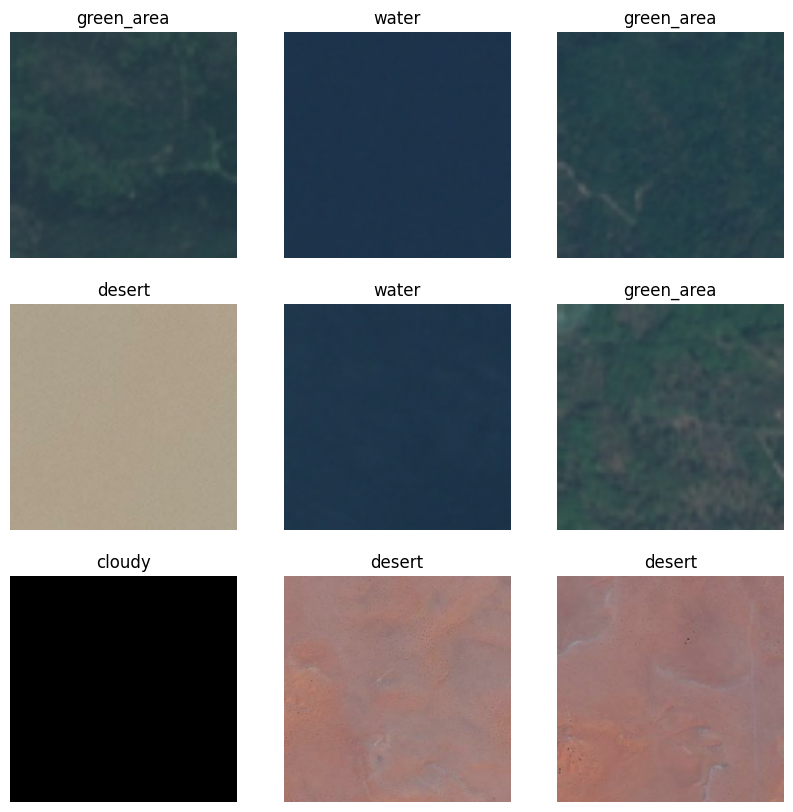

In [6]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])]) # Assuming you have a list of class names
        plt.axis("off")

## Data Augmentation

In [7]:
print(tf.__version__)

2.16.1


In [8]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [9]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset, ds_size=len(dataset))

print('Size of training dataset batch: %d' % len(train_dataset))
print('Size of validation dataset batch: %d' % len(validation_dataset))
print('Size of test dataset batch: %d' % len(test_dataset))

Size of training dataset batch: 123
Size of validation dataset batch: 35
Size of test dataset batch: 18


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(0.2, 1)
])

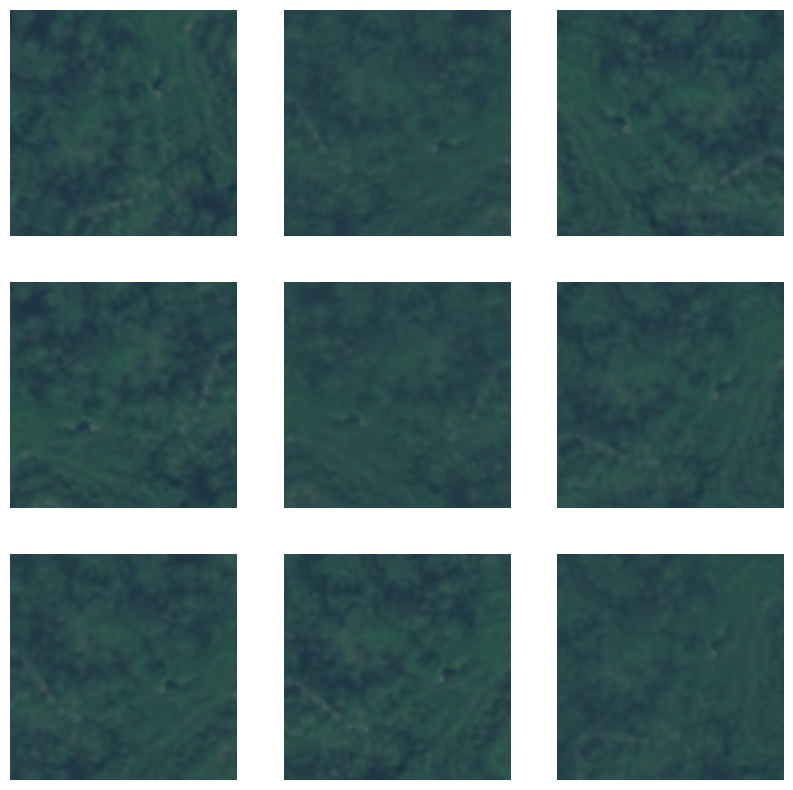

In [12]:
for image, _ in train_dataset.take(1):
 plt.figure(figsize=(10, 10))
 first_image = image[0]
 for i in range(9):
   ax = plt.subplot(3, 3, i + 1)
   augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
   plt.imshow(augmented_image[0] / 255)
   plt.axis('off')

## VGG Model

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras import models
from sklearn.metrics import roc_auc_score

### Generate model

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    min_delta=0.001,     
    patience=10,         
    verbose=1,
    restore_best_weights=True  
)


In [15]:
def generate_model(base_model, dataset, num_classes):

    image_batch, label_batch = train_dataset.as_numpy_iterator().next()
    feature_batch = base_model(image_batch)

    base_model.trainable = True
    base_layer_count = len(base_model.layers)
    fine_tune_at = int(base_layer_count * (1/3))
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)

    prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
    prediction_batch = prediction_layer(feature_batch_average)

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [16]:
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
model = generate_model(base_model, dataset, num_classes)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 14,456,580 (55.15 MB)

 Non-trainable params: 260,160 (1016.25 KB)

### Fine Tuning

In [17]:
def build_matrics(classes_num):
    metrics = []
    metrics.append('accuracy')
    for i in range(classes_num):
        metric_name = '{}{}'.format('precision', i)
        metrics.append(tf.keras.metrics.Precision(class_id = i, name=metric_name))

    for i in range(0, classes_num):
        metric_name = '{}{}'.format('recall', i)
        metrics.append(tf.keras.metrics.Recall(class_id=i, name = metric_name))

    metrics.append(tf.keras.metrics.AUC(curve = 'ROC', name = 'roc_auc', multi_label=True, num_labels=classes_num))

    return metrics

In [18]:
metrics = build_matrics(num_classes)
metrics

['accuracy',
 <Precision name=precision0>,
 <Precision name=precision1>,
 <Precision name=precision2>,
 <Precision name=precision3>,
 <Recall name=recall0>,
 <Recall name=recall1>,
 <Recall name=recall2>,
 <Recall name=recall3>,
 <AUC name=roc_auc>]

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 14,456,580 (55.15 MB)

 Non-trainable params: 260,160 (1016.25 KB)

In [20]:
def get_precision_evaluation(history):
  precision = 0.0
  precision_begin = 2
  precision_end = precision_begin + num_classes
  for i in range(precision_begin, precision_end):
    precision += history[i]

  return precision / num_classes

def get_recall_evaluation(history):
  recall = 0.0
  recall_begin = 2 + num_classes
  recall_end = recall_begin + num_classes
  for i in range(recall_begin, recall_end):
    recall += history[i]

  return recall / num_classes

def get_f1_score(precision, recall):
  f1_score = 0.0
  if (precision + recall) != 0:
    f1_score = (2 * precision * recall) / (precision + recall)

  return f1_score

In [21]:
def check_evaluation(model):
  initial_history = model.evaluate(validation_dataset)

  initial_precision = get_precision_evaluation(initial_history)
  initial_recall = get_recall_evaluation(initial_history)
  initial_f1_score = get_f1_score(initial_precision, initial_recall)
  initial_roc_auc_index = 2 + (2 * num_classes)

  print("Initial loss: {:.2f}".format(initial_history[0]))
  print("Initial accuracy: {:.2f}".format(initial_history[1]))
  print("Initial precision: {:.2f}".format(initial_precision))
  print("Initial recall: {:.2f}".format(initial_recall))
  print("Initial F1 score: {:.2f}".format(initial_f1_score))
  print("Initial ROC: {:.2f}".format(initial_history[initial_roc_auc_index]))

In [22]:
check_evaluation(model)

35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 725ms/step - accuracy: 0.1501 - loss: 1.8681 - precision0: 0.0000e+00 - precision1: 0.6265 - precision2: 0.4612 - precision3: 0.0088 - recall0: 0.0000e+00 - recall1: 0.1435 - recall2: 0.2618 - recall3: 6.5108e-04 - roc_auc: 0.4407
Initial loss: 1.88
Initial accuracy: 0.15
Initial precision: 0.30
Initial recall: 0.09
Initial F1 score: 0.14
Initial ROC: 0.43


### Training the model

In [23]:
initial_epochs = 30

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping])

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8611 - loss: 0.3844 - precision0: 0.9001 - precision1: 0.9375 - precision2: 0.9025 - precision3: 0.9089 - recall0: 0.7354 - recall1: 0.9167 - recall2: 0.8578 - recall3: 0.8289 - roc_auc: 0.9595 - val_accuracy: 0.9982 - val_loss: 0.0085 - val_precision0: 1.0000 - val_precision1: 1.0000 - val_precision2: 0.9931 - val_precision3: 1.0000 - val_recall0: 1.0000 - val_recall1: 1.0000 - val_recall2: 1.0000 - val_recall3: 0.9940 - val_roc_auc: 0.9995
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9887 - loss: 0.0469 - precision0: 1.0000 - precision1: 1.0000 - precision2: 0.9834 - precision3: 0.9745 - recall0: 1.0000 - recall1: 1.0000 - recall2: 0.9738 - recall3: 0.9839 - roc_auc: 0.9982 - val_accuracy: 0.9982 - val_loss: 0.0051 - val_precision0: 1.0000 - val_precision1: 1.0000 - val_precision2: 1.0000 - val_precision3: 0.9938 - val_recall0: 1.0000 - val_recall1: 1.0000 - val_recall2: 0.9930 - val_recall3: 1.0

In [27]:
stopped_epoch = early_stopping.stopped_epoch
print(f"Training stopped at epoch {stopped_epoch}")

Training stopped at epoch 15


### Evaluation

In [37]:

def get_precision_histories(history, stopped_epoch):
  precision_history = [0] * stopped_epoch
  val_precision_history = [0] * stopped_epoch
  for i in range(0, num_classes):
    metric_name = '{}{}'.format('precision', i)
    val_metric_name = 'val_' + metric_name
    precision_history = [sum(x) for x in zip(precision_history, history.history[metric_name])]
    val_precision_history = [sum(x) for x in zip(val_precision_history, history.history[val_metric_name])]

  for i in range(0, stopped_epoch):
    precision_history[i] = precision_history[i] / num_classes
    val_precision_history[i] = val_precision_history[i] / num_classes

  # print(val_precision_history)
  return precision_history, val_precision_history


def get_recall_histories(history, stopped_epoch):
  recall_history = [0] * stopped_epoch
  val_recall_history = [0] * stopped_epoch
  for i in range(0, num_classes):
    metric_name = '{}{}'.format('recall', i)
    val_metric_name = 'val_' + metric_name
    recall_history = [sum(x) for x in zip(recall_history, history.history[metric_name])]
    val_recall_history = [sum(x) for x in zip(val_recall_history, history.history[val_metric_name])]
  print("Sum of val_recalls before dividing:", val_recall_history)

  for i in range(0, stopped_epoch):
    recall_history[i] = recall_history[i] / num_classes
    val_recall_history[i] = val_recall_history[i] / num_classes

  print(val_recall_history)

  return recall_history, val_recall_history


def calculate_f1_scores(precision, recall, val_precision, val_recall):
  f1_score_temp = np.empty(len(precision))
  val_f1_score_temp = np.empty(len(f1_score_temp))
  for i in range(len(precision)):
    harmonic_avg = 0.0
    if (precision[i] + recall[i]) != 0:
      harmonic_avg = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])

    val_harmonic_avg = 0.0
    if (val_precision[i] + val_recall [i]) != 0:
      val_harmonic_avg = (2 * val_precision[i] * val_recall [i]) / (val_precision[i] + val_recall [i])

    np.put(f1_score_temp, i, harmonic_avg)
    np.put(val_f1_score_temp, i, val_harmonic_avg)
  return [f1_score_temp, val_f1_score_temp]

In [40]:

def evaluation(model, history):
    metric_name_loss = model.metrics_names[0]
    metric_name_accuracy = 'accuracy'
    acc = history.history[metric_name_accuracy]
    val_acc = history.history['val_' + metric_name_accuracy]

    loss = history.history[metric_name_loss]
    val_loss = history.history['val_' + metric_name_loss]

    roc_auc = history.history['roc_auc']
    val_roc_auc = history.history['val_roc_auc']

    precision, val_precision = get_precision_histories(history, stopped_epoch)

    recall, val_recall = get_recall_histories(history, stopped_epoch)

    f1_score, val_f1_score = calculate_f1_scores(precision, recall, val_precision, val_recall)
    return acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score


In [41]:
acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score = evaluation(model, history)


Sum of val_recalls before dividing: [3.993975877761841, 3.9929824471473694, 3.9888776540756226, 3.9901195764541626, 3.996575355529785, 3.99676376581192, 3.993503987789154, 3.99319726228714, 4.0, 4.0, 4.0, 3.996894419193268, 4.0, 3.947842061519623, 3.993254601955414]
[0.9984939694404602, 0.9982456117868423, 0.9972194135189056, 0.9975298941135406, 0.9991438388824463, 0.99919094145298, 0.9983759969472885, 0.998299315571785, 1.0, 1.0, 1.0, 0.999223604798317, 1.0, 0.9869605153799057, 0.9983136504888535]


### Evaluation Visualization


In [42]:
def plot(acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score):
  print(val_precision)
  print(val_recall)
  print(val_f1_score)
  
  plt.figure(figsize=(30, 20))

  plt.subplot(3, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
  plt.title('Training and Validation Accuracy')
  plt.xlabel('epoch')

  plt.subplot(3, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')

  plt.subplot(3, 2, 3)
  plt.plot(precision, label='Training Precision')
  plt.plot(val_precision, label='Validation Precision')
  plt.legend(loc='lower right')
  plt.ylabel('Precision')
  plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
  plt.title('Training and Validation Precision')
  plt.xlabel('epoch')

  plt.subplot(3, 2, 4)
  plt.plot(recall, label='Training Recall')
  plt.plot(val_recall, label='Validation Recall')
  plt.legend(loc='lower right')
  plt.ylabel('Recall')
  plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
  plt.title('Training and Validation Recall')
  plt.xlabel('epoch')

  plt.subplot(3, 2, 5)
  plt.plot(f1_score, label='Training F1 Score')
  plt.plot(val_f1_score, label='Validation F1 Score')
  plt.legend(loc='upper left')
  plt.ylabel('F1 Score')
  plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
  plt.title('Training and Validation F1 Score')
  plt.xlabel('epoch')

  plt.subplot(3, 2, 6)
  plt.plot(roc_auc, label='Training ROC AUC')
  plt.plot(val_roc_auc, label='Validation ROC AUC')
  plt.legend(loc='upper left')
  plt.ylabel('ROC AUC')
  plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
  plt.title('Training and Validation ROC AUC')
  plt.xlabel('epoch')

[0.998281791806221, 0.9984423667192459, 0.9974972009658813, 0.998344212770462, 0.999163880944252, 0.9991776347160339, 0.9983759969472885, 0.9983552694320679, 1.0, 1.0, 1.0, 0.9991467595100403, 1.0, 0.9882445186376572, 0.9983136504888535]
[0.9984939694404602, 0.9982456117868423, 0.9972194135189056, 0.9975298941135406, 0.9991438388824463, 0.99919094145298, 0.9983759969472885, 0.998299315571785, 1.0, 1.0, 1.0, 0.999223604798317, 1.0, 0.9869605153799057, 0.9983136504888535]
[0.99838787 0.99834398 0.99735829 0.99793689 0.99915386 0.99918429
 0.998376   0.99832729 1.         1.         1.         0.99918518
 1.         0.9876021  0.99831365]


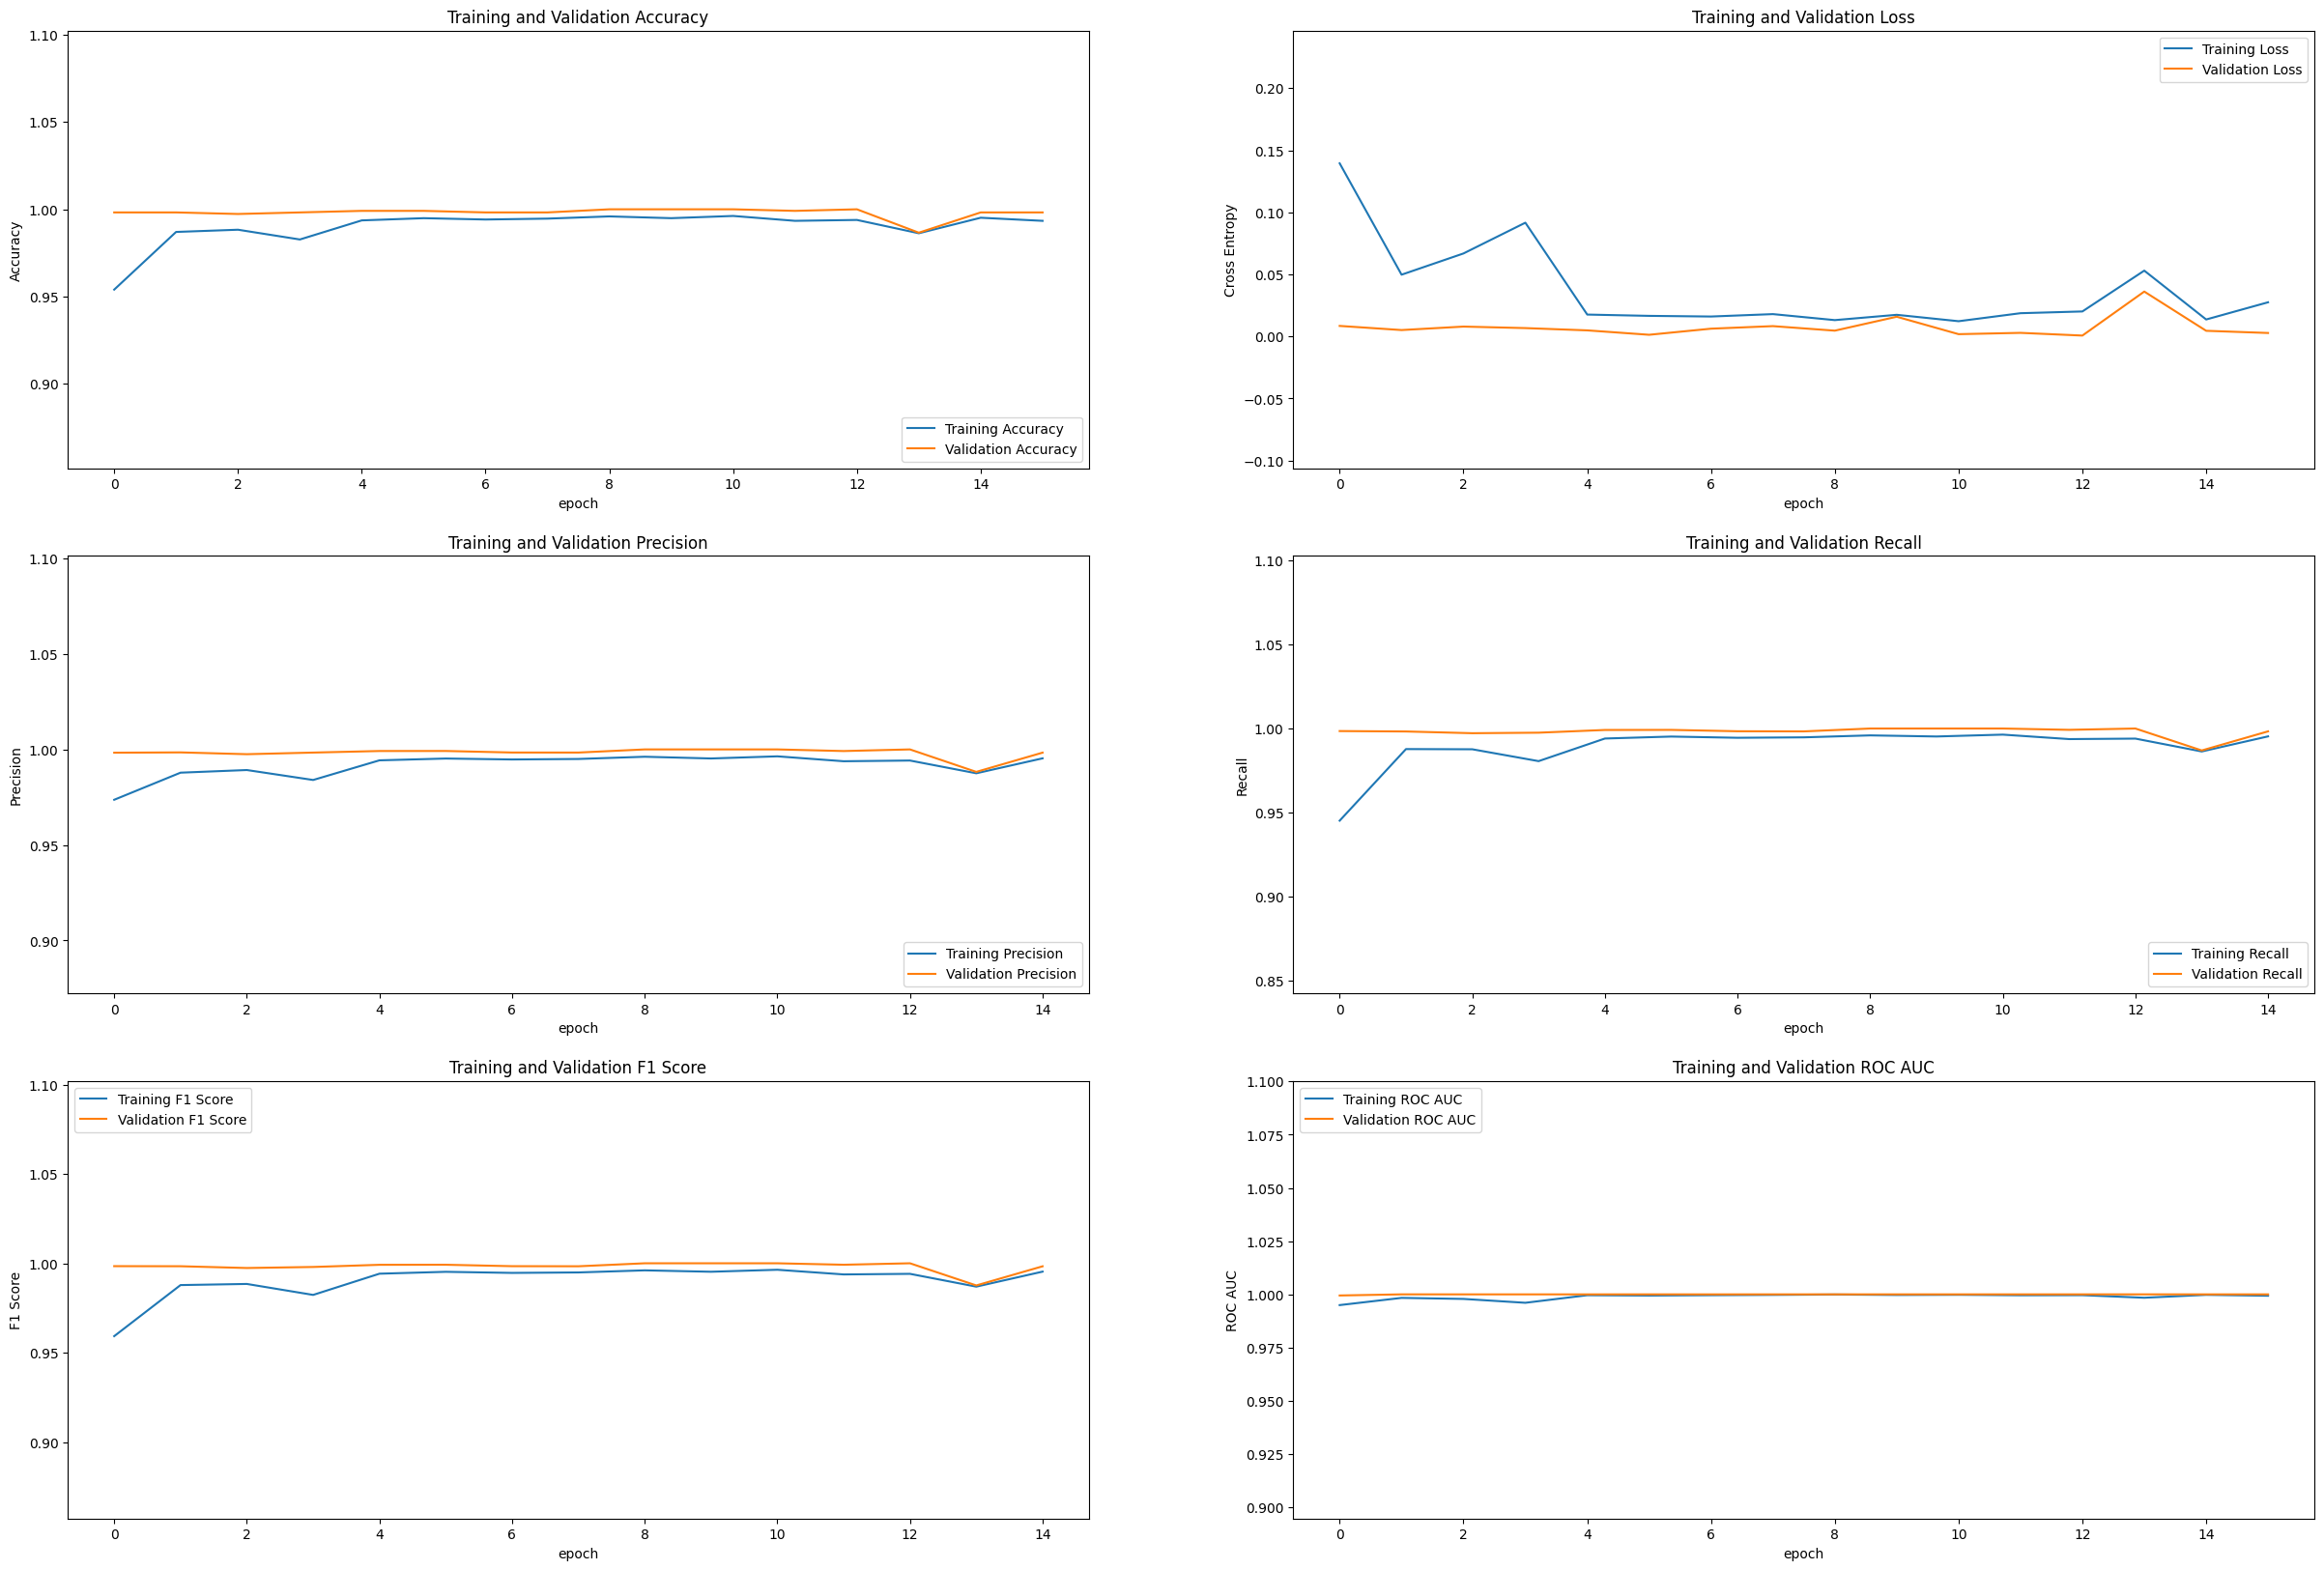

In [43]:
plot(acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score)

### Evaluation on test set

In [44]:
test_history = model.evaluate(test_dataset)

test_precision = get_precision_evaluation(test_history)
test_recall = get_recall_evaluation(test_history)
test_f1_score = get_f1_score(test_precision, test_recall)
test_roc_auc_index = 2 + (2 * num_classes)

print("test loss: {:.2f}".format(test_history[0]))
print("test accuracy: {:.2f}".format(test_history[1]))
print("test precision: {:.2f}".format(test_precision))
print("test recall: {:.2f}".format(test_recall))
print("test F1 score: {:.2f}".format(test_f1_score))
print("test ROC: {:.2f}".format(test_history[test_roc_auc_index]))

18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 737ms/step - accuracy: 1.0000 - loss: 0.0021 - precision0: 1.0000 - precision1: 1.0000 - precision2: 1.0000 - precision3: 1.0000 - recall0: 1.0000 - recall1: 1.0000 - recall2: 1.0000 - recall3: 1.0000 - roc_auc: 1.0000
test loss: 0.00
test accuracy: 1.00
test precision: 1.00
test recall: 1.00
test F1 score: 1.00
test ROC: 1.00


## MobileNetV2

In [65]:
from tensorflow.keras.applications import MobileNetV2

### Generate the model

In [66]:
base_model2 = MobileNetV2(weights='imagenet', include_top = False, input_shape=(224,224,3))
model2 = generate_model(base_model2, dataset, num_classes)
model2.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 2,179,716 (8.31 MB)

 Non-trainable params: 83,392 (325.75 KB)

### Fine Tuning

In [67]:
metrics = build_matrics(num_classes)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

In [68]:
check_evaluation(model2)

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.2413 - loss: 1.8842 - precision0: 0.0000e+00 - precision1: 0.0753 - precision2: 0.0000e+00 - precision3: 0.0075 - recall0: 0.0000e+00 - recall1: 0.1133 - recall2: 0.0000e+00 - recall3: 0.0026 - roc_auc: 0.4358
Initial loss: 1.88
Initial accuracy: 0.23
Initial precision: 0.02
Initial recall: 0.03
Initial F1 score: 0.03
Initial ROC: 0.44


### Training the model

In [69]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',   
    min_delta=0.001,         
    patience=10,             
    verbose=1,               
    restore_best_weights=True
)

In [70]:
initial_epochs = 30

history2 = model2.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping])

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 36s 221ms/step - accuracy: 0.9007 - loss: 0.2452 - precision0: 0.9703 - precision1: 0.9104 - precision2: 0.9374 - precision3: 0.9579 - recall0: 0.9237 - recall1: 0.9109 - recall2: 0.8364 - recall3: 0.8369 - roc_auc: 0.9795 - val_accuracy: 0.2857 - val_loss: 2.7412 - val_precision0: 0.3131 - val_precision1: 1.0000 - val_precision2: 0.0000e+00 - val_precision3: 0.2308 - val_recall0: 1.0000 - val_recall1: 0.0118 - val_recall2: 0.0000e+00 - val_recall3: 0.0734 - val_roc_auc: 0.7402
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.9931 - loss: 0.0264 - precision0: 1.0000 - precision1: 0.9990 - precision2: 0.9868 - precision3: 0.9885 - recall0: 1.0000 - recall1: 0.9991 - recall2: 0.9896 - recall3: 0.9855 - roc_auc: 0.9997 - val_accuracy: 0.4839 - val_loss: 3.3985 - val_precision0: 0.8742 - val_precision1: 1.0000 - val_precision2: 0.0000e+00 - val_precision3: 0.3270 - val_recall0: 1.0000 - val_recall1: 0.0045 - val_recall2: 0.0000e+0

In [71]:
stopped_epoch = early_stopping.stopped_epoch
print(f"Training stopped at epoch {stopped_epoch}")

Training stopped at epoch 29


### Evaluation

In [72]:
acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score = evaluation(model2, history2)


Sum of val_recalls before dividing: [1.0852375980466604, 1.8454135684296489, 2.0, 2.0, 2.0, 2.022123893722892, 2.935748458839953, 3.3255371153354645, 3.096958488225937, 3.64157497882843, 3.940625011920929, 3.961805582046509, 3.9382766485214233, 3.980830669403076, 3.973013937473297, 3.7934426069259644, 3.9603960514068604, 3.8424657583236694, 3.9795918464660645, 3.996688723564148, 4.0, 3.9906832575798035, 3.98257839679718, 3.996515691280365, 3.990332305431366, 4.0, 4.0, 3.9934853315353394, 4.0]
[0.2713093995116651, 0.4613533921074122, 0.5, 0.5, 0.5, 0.505530973430723, 0.7339371147099882, 0.8313842788338661, 0.7742396220564842, 0.9103937447071075, 0.9851562529802322, 0.9904513955116272, 0.9845691621303558, 0.995207667350769, 0.9932534843683243, 0.9483606517314911, 0.9900990128517151, 0.9606164395809174, 0.9948979616165161, 0.999172180891037, 1.0, 0.9976708143949509, 0.995644599199295, 0.9991289228200912, 0.9975830763578415, 1.0, 1.0, 0.9983713328838348, 1.0]


### Evaluation Visualization

[0.385969664901495, 0.5503085032105446, 0.34153175354003906, 0.3455357179045677, 0.3443688154220581, 0.5942521616816521, 0.8790983557701111, 0.9023668617010117, 0.8818933814764023, 0.937810942530632, 0.9842715263366699, 0.9911575615406036, 0.986486479640007, 0.9949324280023575, 0.9933464080095291, 0.9556338042020798, 0.9904761910438538, 0.9662756621837616, 0.9946619272232056, 0.9991467595100403, 1.0, 0.9973684251308441, 0.9958745837211609, 0.9991554021835327, 0.9975278526544571, 1.0, 1.0, 0.998281791806221, 1.0]
[0.2713093995116651, 0.4613533921074122, 0.5, 0.5, 0.5, 0.505530973430723, 0.7339371147099882, 0.8313842788338661, 0.7742396220564842, 0.9103937447071075, 0.9851562529802322, 0.9904513955116272, 0.9845691621303558, 0.995207667350769, 0.9932534843683243, 0.9483606517314911, 0.9900990128517151, 0.9606164395809174, 0.9948979616165161, 0.999172180891037, 1.0, 0.9976708143949509, 0.995644599199295, 0.9991289228200912, 0.9975830763578415, 1.0, 1.0, 0.9983713328838348, 1.0]
[0.3186384

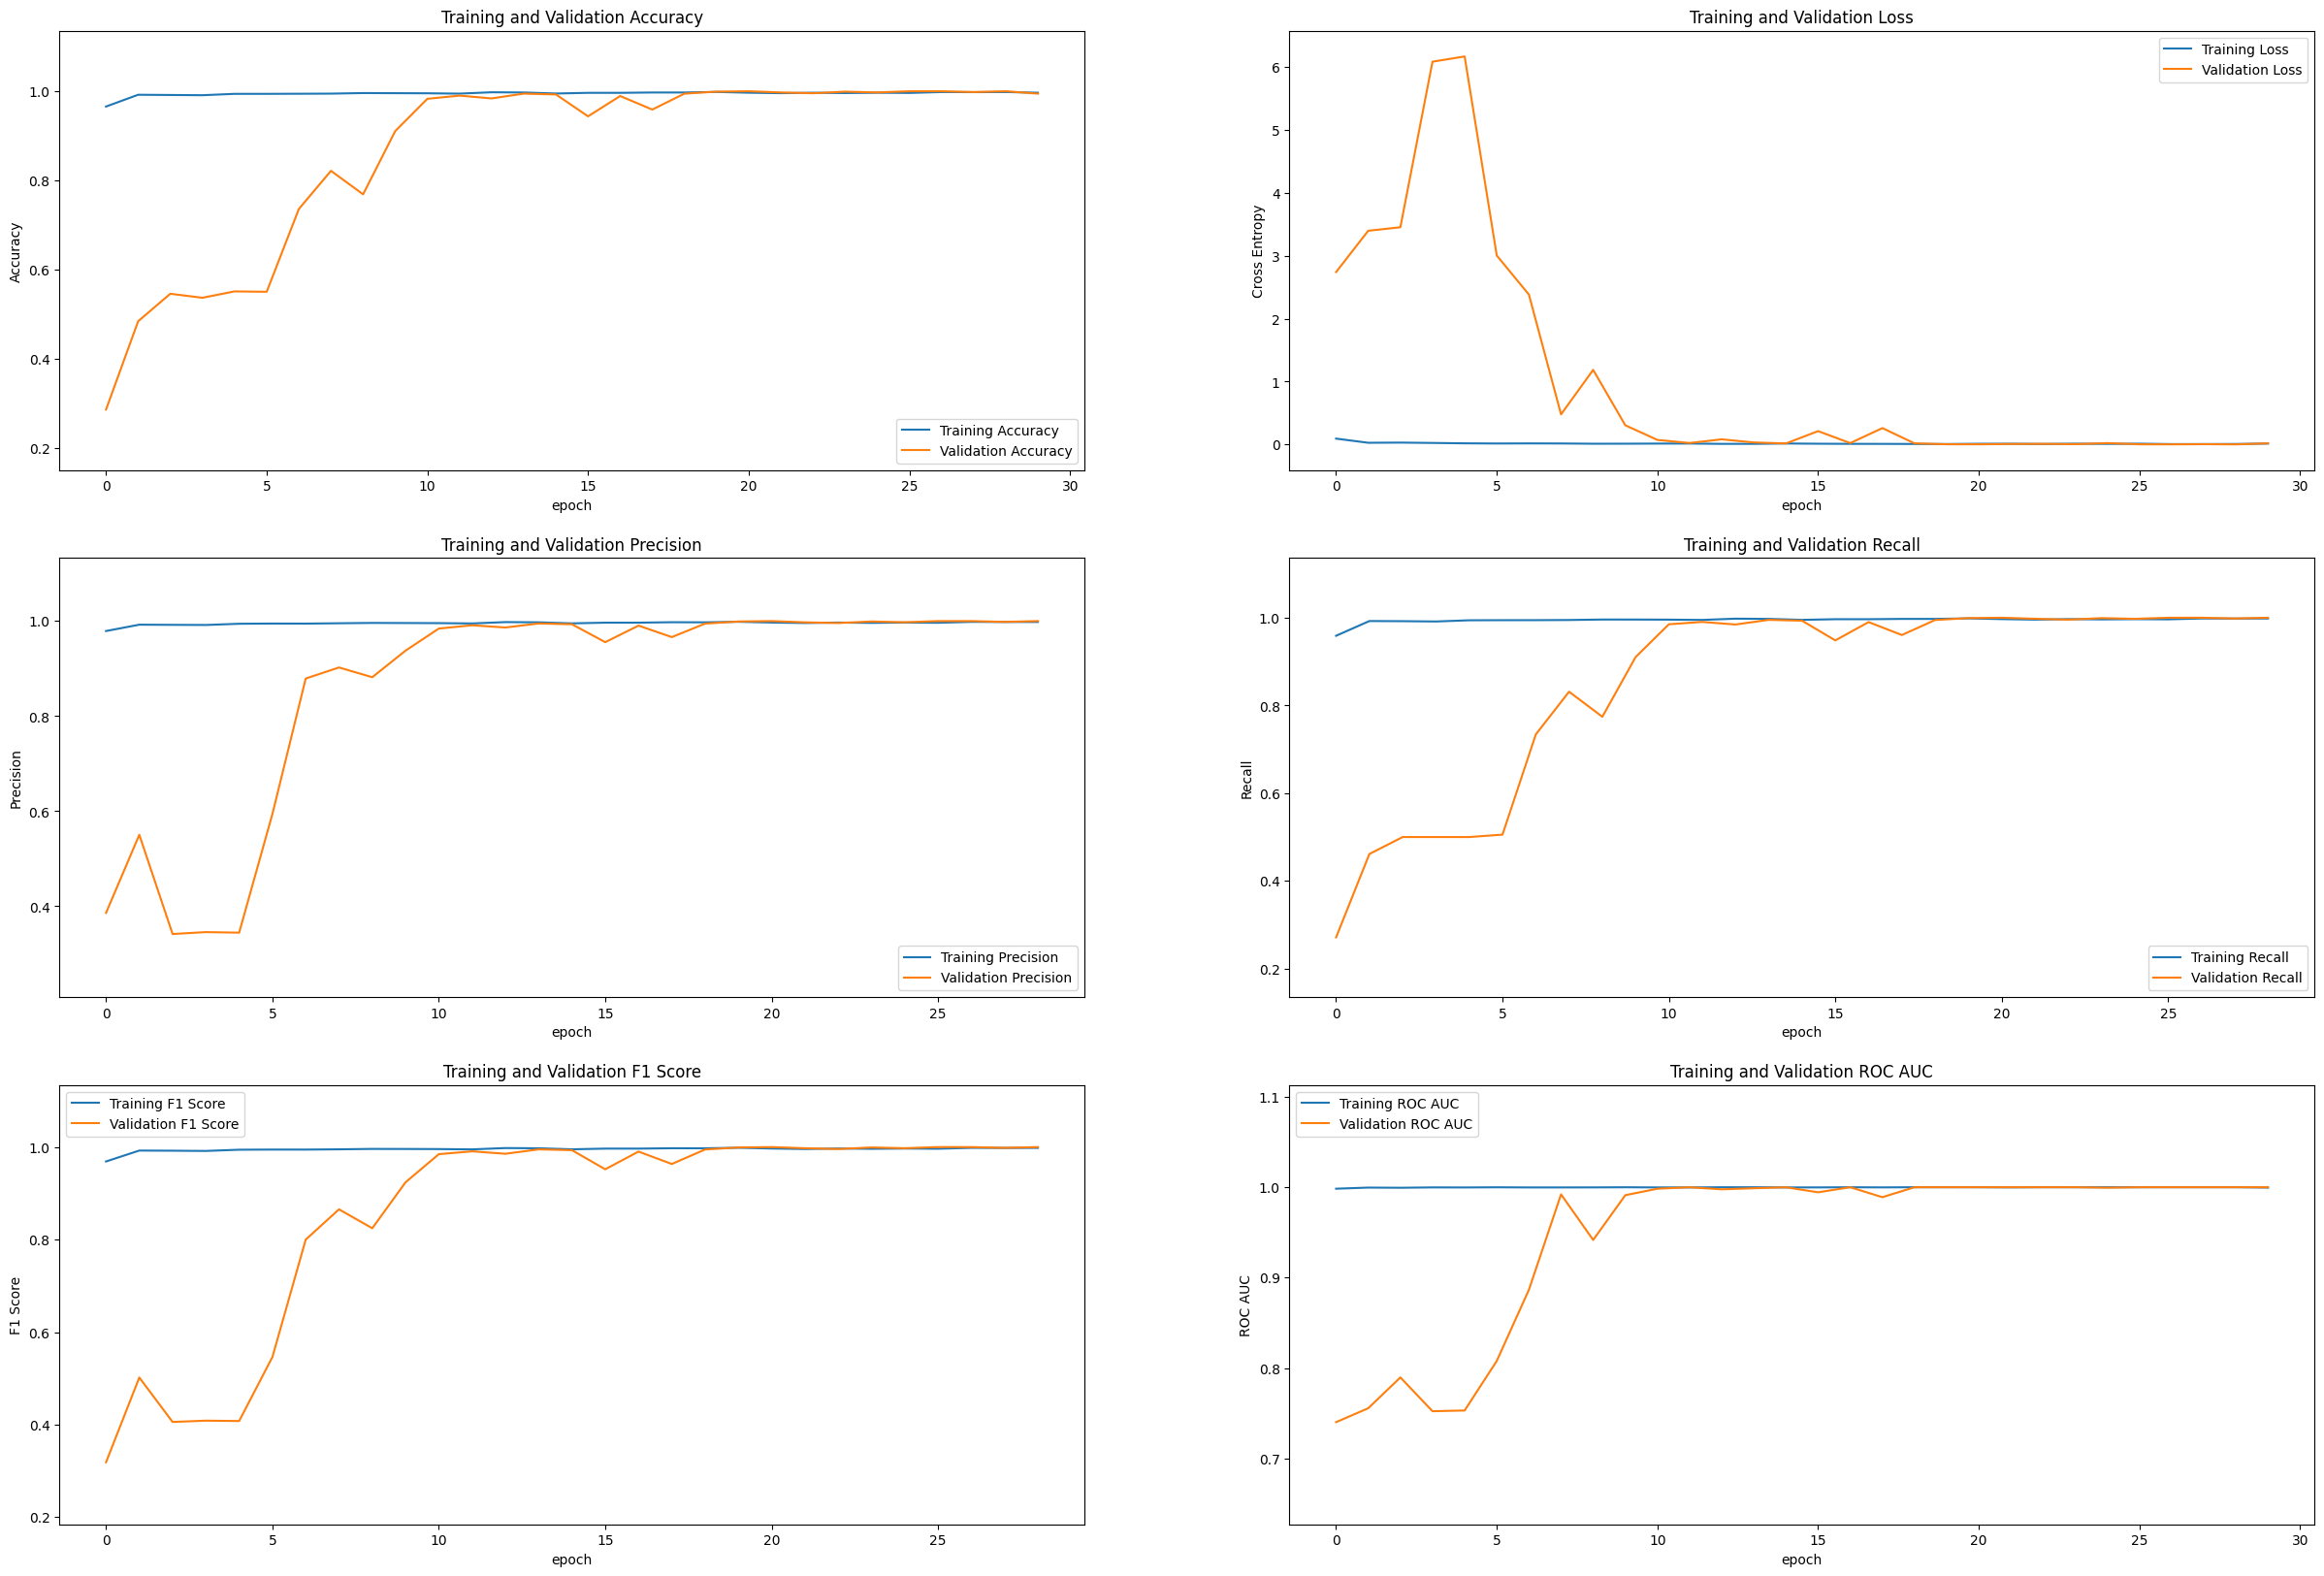

In [73]:
plot(acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score)

In [74]:
test_history = model2.evaluate(test_dataset)

test_precision = get_precision_evaluation(test_history)
test_recall = get_recall_evaluation(test_history)
test_f1_score = get_f1_score(test_precision, test_recall)
test_roc_auc_index = 2 + (2 * num_classes)

print("test loss: {:.2f}".format(test_history[0]))
print("test accuracy: {:.2f}".format(test_history[1]))
print("test precision: {:.2f}".format(test_precision))
print("test recall: {:.2f}".format(test_recall))
print("test F1 score: {:.2f}".format(test_f1_score))
print("test ROC: {:.2f}".format(test_history[test_roc_auc_index]))

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 1.0000 - loss: 0.0011 - precision0: 1.0000 - precision1: 1.0000 - precision2: 1.0000 - precision3: 1.0000 - recall0: 1.0000 - recall1: 1.0000 - recall2: 1.0000 - recall3: 1.0000 - roc_auc: 1.0000   
test loss: 0.00
test accuracy: 1.00
test precision: 1.00
test recall: 1.00
test F1 score: 1.00
test ROC: 1.00


## Xception

In [54]:
from tensorflow.keras.applications import Xception

### Generate the model

In [55]:
base_model3 = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model3 = generate_model(base_model3, dataset, num_classes)
model3.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 18,095,868 (69.03 MB)

 Non-trainable params: 2,773,808 (10.58 MB)

### Fine tuning

In [56]:
metrics = build_matrics(num_classes)
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

In [57]:
check_evaluation(model3)

35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 345ms/step - accuracy: 0.5202 - loss: 19.9517 - precision0: 0.0000e+00 - precision1: 0.0000e+00 - precision2: 0.0000e+00 - precision3: 0.3192 - recall0: 0.0000e+00 - recall1: 0.0000e+00 - recall2: 0.0000e+00 - recall3: 1.0000 - roc_auc: 0.5758
Initial loss: 19.51
Initial accuracy: 0.53
Initial precision: 0.08
Initial recall: 0.25
Initial F1 score: 0.13
Initial ROC: 0.58


### Training the model

In [59]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    min_delta=0.001,     
    patience=10,         
    verbose=1,
    restore_best_weights=True  
)

In [60]:
initial_epochs = 30

history3 = model3.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping])

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 119s 964ms/step - accuracy: 0.9909 - loss: 0.0284 - precision0: 1.0000 - precision1: 1.0000 - precision2: 0.9806 - precision3: 0.9850 - recall0: 1.0000 - recall1: 1.0000 - recall2: 0.9846 - recall3: 0.9814 - roc_auc: 0.9997 - val_accuracy: 0.9982 - val_loss: 0.0064 - val_precision0: 1.0000 - val_precision1: 1.0000 - val_precision2: 0.9931 - val_precision3: 1.0000 - val_recall0: 1.0000 - val_recall1: 1.0000 - val_recall2: 1.0000 - val_recall3: 0.9931 - val_roc_auc: 1.0000
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 119s 964ms/step - accuracy: 0.9937 - loss: 0.0232 - precision0: 1.0000 - precision1: 1.0000 - precision2: 0.9845 - precision3: 0.9923 - recall0: 1.0000 - recall1: 1.0000 - recall2: 0.9923 - recall3: 0.9844 - roc_auc: 0.9995 - val_accuracy: 0.9973 - val_loss: 0.0104 - val_precision0: 1.0000 - val_precision1: 1.0000 - val_precision2: 1.0000 - val_precision3: 0.9889 - val_recall0: 1.0000 - val_recall1: 1.0000 - val_recall2: 0.9903 - val_recall

In [61]:
stopped_epoch = early_stopping.stopped_epoch
print(f"Training stopped at epoch {stopped_epoch}")

Training stopped at epoch 10


### Evaluation

In [62]:
acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score = evaluation(model3, history3)


Sum of val_recalls before dividing: [3.993127167224884, 3.9902912378311157, 3.537162184715271, 3.983164966106415, 3.973770499229431, 3.4841249585151672, 3.182584583759308, 3.9832776188850403, 3.9896907210350037, 3.9834983348846436]
[0.998281791806221, 0.9975728094577789, 0.8842905461788177, 0.9957912415266037, 0.9934426248073578, 0.8710312396287918, 0.795646145939827, 0.9958194047212601, 0.9974226802587509, 0.9958745837211609]


### Evaluation Visualization


[0.9982638955116272, 0.9972324669361115, 0.921241044998169, 0.9969696998596191, 0.9941275119781494, 0.9241379350423813, 0.8990683257579803, 0.9957770258188248, 0.9975806474685669, 0.995748296380043]
[0.998281791806221, 0.9975728094577789, 0.8842905461788177, 0.9957912415266037, 0.9934426248073578, 0.8710312396287918, 0.795646145939827, 0.9958194047212601, 0.9974226802587509, 0.9958745837211609]
[0.99827284 0.99740261 0.9023877  0.99638012 0.99378495 0.89679906
 0.8442015  0.99579821 0.99750166 0.99581144]


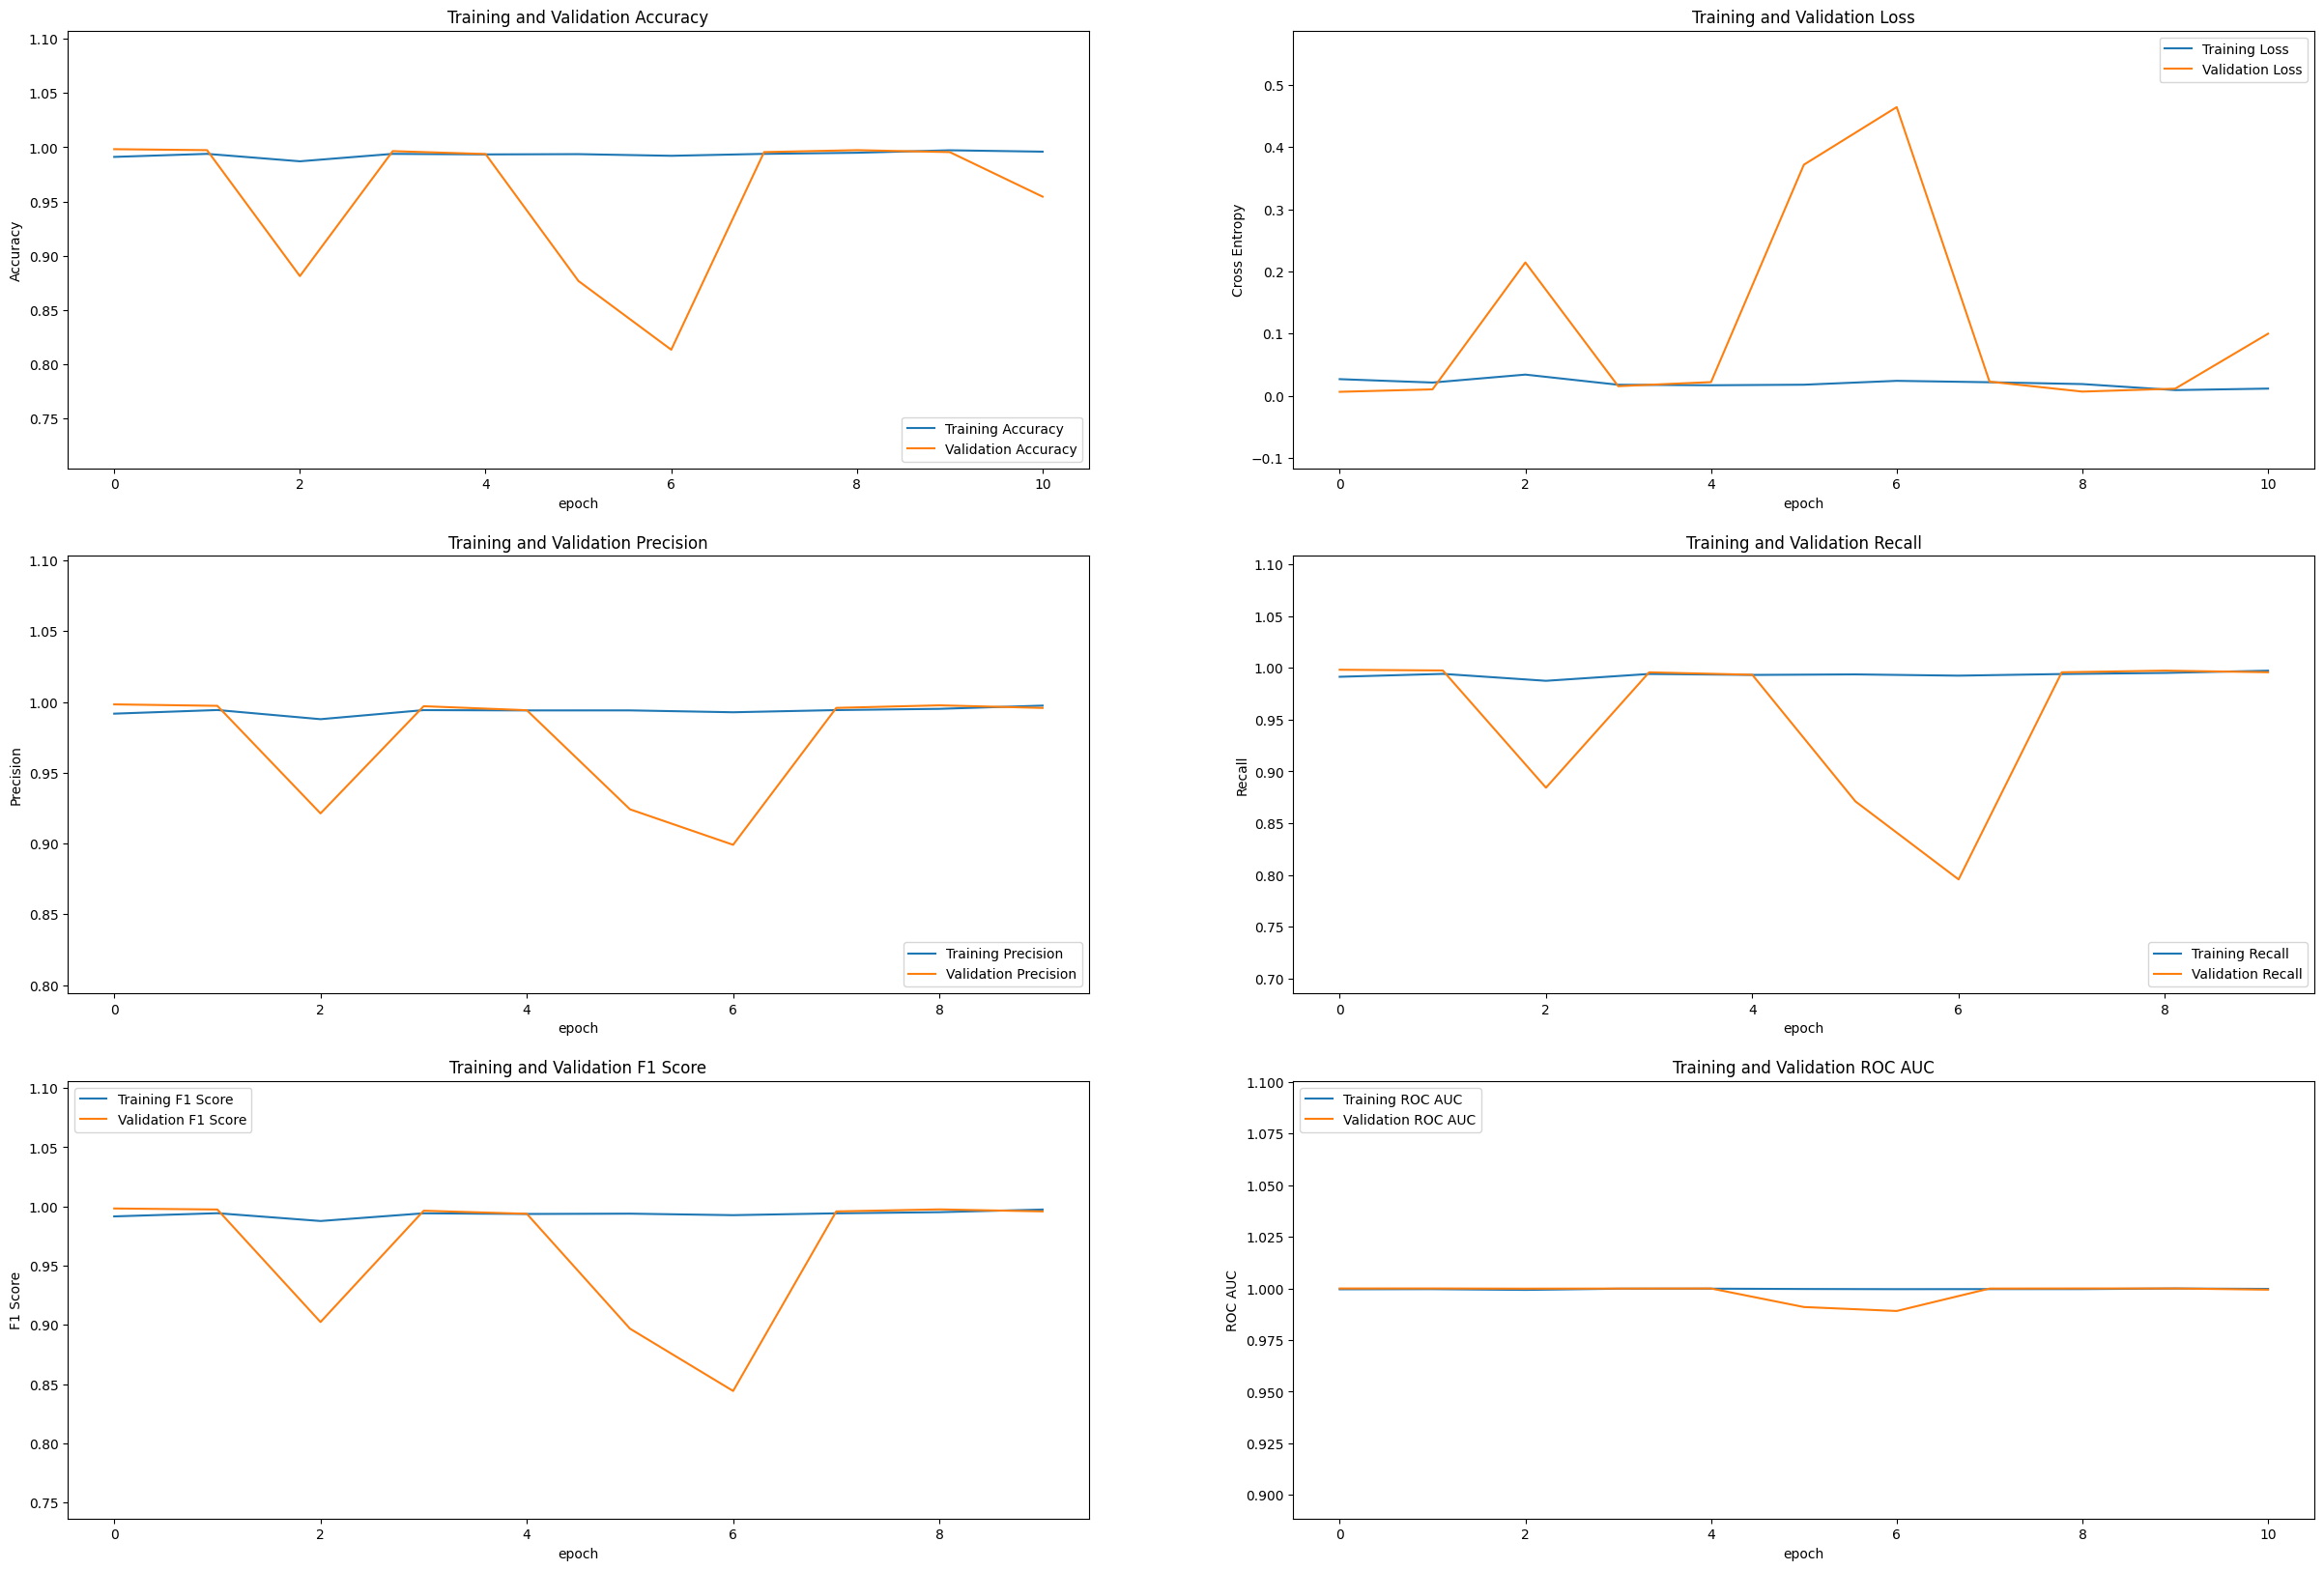

In [63]:
plot(acc, val_acc, loss, val_loss, roc_auc, val_roc_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score)

In [64]:
test_history = model3.evaluate(test_dataset)

test_precision = get_precision_evaluation(test_history)
test_recall = get_recall_evaluation(test_history)
test_f1_score = get_f1_score(test_precision, test_recall)
test_roc_auc_index = 2 + (2 * num_classes)

print("test loss: {:.2f}".format(test_history[0]))
print("test accuracy: {:.2f}".format(test_history[1]))
print("test precision: {:.2f}".format(test_precision))
print("test recall: {:.2f}".format(test_recall))
print("test F1 score: {:.2f}".format(test_f1_score))
print("test ROC: {:.2f}".format(test_history[test_roc_auc_index]))

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.9990 - loss: 0.0067 - precision0: 1.0000 - precision1: 1.0000 - precision2: 1.0000 - precision3: 0.9962 - recall0: 1.0000 - recall1: 1.0000 - recall2: 0.9966 - recall3: 1.0000 - roc_auc: 1.0000
test loss: 0.01
test accuracy: 1.00
test precision: 1.00
test recall: 1.00
test F1 score: 1.00
test ROC: 1.00
